In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix



In [2]:

# Cargar los datos
hotels = pd.read_csv("../data/raw/hotel_bookings.csv")

# Imputar valores faltantes para variables numéricas y categóricas
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')
num_columns = hotels.select_dtypes(include=['float64', 'int64']).columns
cat_columns = hotels.select_dtypes(include=['object']).columns
hotels[num_columns] = num_imputer.fit_transform(hotels[num_columns])
hotels[cat_columns] = cat_imputer.fit_transform(hotels[cat_columns])

# Codificar variables categóricas
label_encoder = LabelEncoder()
for column in cat_columns:
    hotels[column] = label_encoder.fit_transform(hotels[column])

# Ingeniería de características
hotels['total_stay'] = hotels['no_of_weekend_nights'] + hotels['no_of_week_nights']
hotels['weekend_proportion'] = hotels['no_of_weekend_nights'] / hotels['total_stay']
hotels['weekend_proportion'].fillna(0, inplace=True)


In [3]:

# Dividir los datos en características y variable objetivo
X = hotels.drop('booking_status', axis=1)
y = hotels['booking_status']


In [4]:

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [6]:


# Opciones para la regresión logística
logistic_regression_options = {
    'max_iter': 5000,
    'solver': 'saga',
    'random_state': 42
}

# Escalar los datos antes de alimentarlos al modelo
scaler = StandardScaler()

# Definir los modelos base para el stacking con pipelines para incluir el escalado
base_models_scaled = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),  # No necesita escalado
    ('lr', make_pipeline(StandardScaler(), LogisticRegression(**logistic_regression_options))),
    ('dt', DecisionTreeClassifier(random_state=42)),  # No necesita escalado
    ('svc', make_pipeline(StandardScaler(), SVC(random_state=42)))
]

# El meta-modelo también debería ser escalado si incluye LogisticRegression
meta_model_scaled = make_pipeline(StandardScaler(), LogisticRegression(**logistic_regression_options))

# Crear el modelo de Stacking con los modelos base escalados
stacking_model_scaled = StackingClassifier(estimators=base_models_scaled, final_estimator=meta_model_scaled, cv=3)



In [8]:


# Entrenar el modelo de Stacking
stacking_model_scaled.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = stacking_model_scaled.predict(X_test)

# Evaluar el modelo
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Reporte de Clasificación:")
print(report)
print("Matriz de Confusión:")
print(conf_matrix)


Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.86      0.79      0.83      3607
           1       0.90      0.94      0.92      7276

    accuracy                           0.89     10883
   macro avg       0.88      0.86      0.87     10883
weighted avg       0.89      0.89      0.89     10883

Matriz de Confusión:
[[2858  749]
 [ 461 6815]]



The classification report results provide a detailed evaluation of the performance of a classification model on a test dataset. Here's the interpretation of the metrics presented in the report:

For Class 0:

Precision: 0.86
This means that 86% of the predictions classified as Class 0 were correct.
Recall: 0.79
79% of the actual instances of Class 0 were correctly identified by the model.
F1-score: 0.83
The F1-score combines precision and recall and is equal to 0.83 for Class 0.
Support: 3607
There are a total of 3607 actual instances of Class 0 in the test set.
For Class 1:

Precision: 0.90
90% of the predictions classified as Class 1 were correct.
Recall: 0.94
94% of the actual instances of Class 1 were correctly identified by the model.
F1-score: 0.92
The F1-score for Class 1 is 0.92, indicating a good balance between precision and recall.
Support: 7276
There are a total of 7276 actual instances of Class 1 in the test set.
Overall Accuracy: 0.89

The overall accuracy is 89%, which means that 89% of all predictions made by the model are correct.
Weighted Average:

The report also provides a weighted average of all the metrics. This is useful when classes have significant imbalance. In this case, the weighted average is 89%, indicating good overall model performance.
Macro Average (Macro Avg):

The macro average is a simple average of precision, recall, and F1-score for both classes. In this case, the macro average is 87%, indicating good overall performance in both classes.
In summary, the classification model has very good overall performance, with high precision and recall in both classes and a weighted average F1-score of 89%.

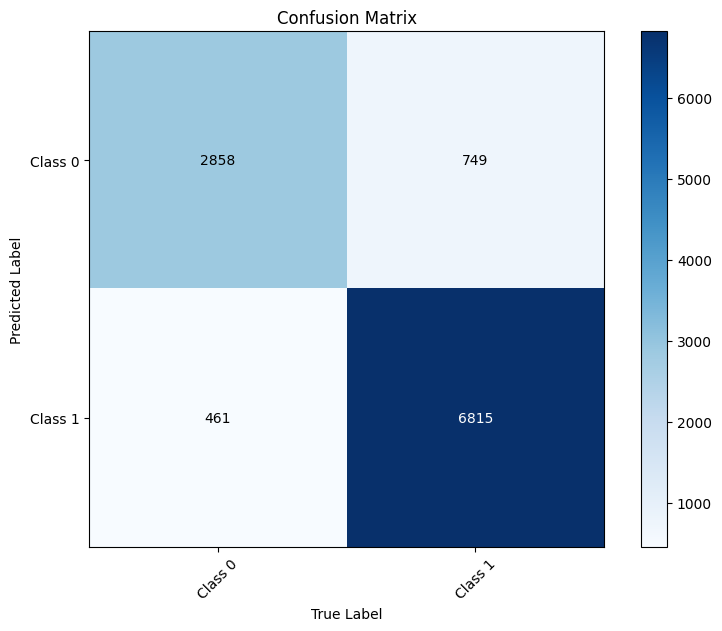

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Define the confusion matrix
confusion_matrix = np.array([[2858, 749],
                              [461, 6815]])

# Create a figure
plt.figure(figsize=(8, 6))

# Create the confusion matrix plot
plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()

# Axis labels
classes = ['Class 0', 'Class 1']
plt.xticks(np.arange(len(classes)), classes, rotation=45)
plt.yticks(np.arange(len(classes)), classes)

# Add values inside the cells
thresh = confusion_matrix.max() / 2
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        plt.text(j, i, format(confusion_matrix[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if confusion_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.xlabel('True Label')
plt.ylabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()


The value 2858 in the first row and first column (top left) indicates that there were 2858 instances that truly belonged to Class 0, and the model correctly predicted them as Class 0.

The value 749 in the first row and second column (top right) indicates that there were 749 instances that truly belonged to Class 0, but the model incorrectly predicted them as Class 1.

The value 461 in the second row and first column (bottom left) indicates that there were 461 instances that truly belonged to Class 1, but the model incorrectly predicted them as Class 0.

The value 6815 in the second row and second column (bottom right) indicates that there were 6815 instances that truly belonged to Class 1, and the model correctly predicted them as Class 1.

Save scaler, logistic regression model & stacking model

In [10]:
import joblib

# Definir el nombre de archivo para guardar el escalador
scaler_filename = "scaler_model.joblib"

# Guardar el escalador en el archivo
joblib.dump(StandardScaler(), scaler_filename)

# Definir el nombre de archivo para guardar el modelo LogisticRegression
logistic_regression_filename = "logistic_regression_model.joblib"

# Guardar el modelo LogisticRegression en el archivo
joblib.dump(meta_model_scaled.named_steps['logisticregression'], logistic_regression_filename)

# Definir el nombre de archivo para guardar el modelo StackingClassifier
stacking_model_filename = "stacking_model.joblib"

# Guardar el modelo StackingClassifier en el archivo
joblib.dump(stacking_model_scaled, stacking_model_filename)


['stacking_model.joblib']